## parallel workflow

In [46]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated
import operator

In [29]:
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float
    bpb: float
    boundary_percent: float
    summary: str

In [30]:
def calculate_sr(state: BatsmanState):
    
    sr = (state['runs'] / state['balls']) * 100
    state['sr'] = sr
    return {'sr': state['sr']}

In [ ]:
def calculate_bpb(state: BatsmanState):

    bpb = state["balls"] / (state["fours"] + state["sixes"])
    state["bpb"] = bpb

    return {"bpb": state["bpb"]}

In [32]:
def calculate_boundary_percent(state: BatsmanState):

    boundary_percent = ((state['fours'] * 4 + state['sixes'] * 6) / state['runs']) * 100
    state['boundary_percent'] = boundary_percent

    return {"boundary_percent": state["boundary_percent"]}

In [33]:
def summary(state: BatsmanState) -> BatsmanState:
    summary_var = f"""
                Strike Rate - {state['sr']} \n
                Balls per boundary - {state['bpb']} \n
                Boundary Percent - {state['boundary_percent']} """
    

    state['summary'] = summary_var

    return state
    

In [34]:
graph = StateGraph(BatsmanState)

graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bpb', calculate_bpb)
graph.add_node("calculate_boundary_percent", calculate_boundary_percent)
graph.add_node("summary", summary)

graph.add_edge(START, 'calculate_sr')
graph.add_edge(START, 'calculate_bpb')
graph.add_edge(START, 'calculate_boundary_percent')

graph.add_edge('calculate_sr', 'summary')
graph.add_edge("calculate_bpb", "summary")
graph.add_edge("calculate_boundary_percent", "summary")

graph.add_edge('summary', END)

workflow = graph.compile()


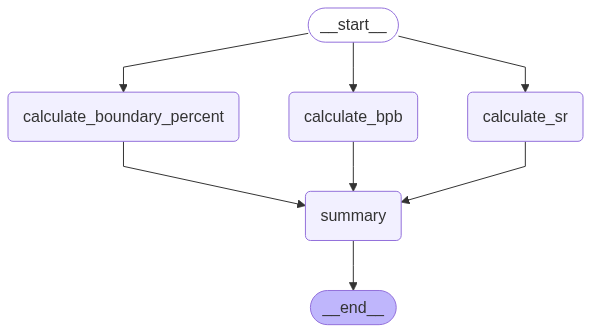

In [35]:
workflow

In [36]:
initial_state: BatsmanState = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4,
    'sr': -1,
    'bpb': -1,
    'boundary_percent': -1,
    'summary': ''
}

workflow.invoke(initial_state)

{'runs': 100,
 'balls': 50,
 'fours': 6,
 'sixes': 4,
 'sr': 200.0,
 'bpb': 5.0,
 'boundary_percent': 48.0,
 'summary': '\n                Strike Rate - 200.0 \n\n                Balls per boundary - 5.0 \n\n                Boundary Percent - 48.0 '}

## UPSC Essay Evaluation

In [63]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict
from pydantic import BaseModel, Field

In [64]:
model = ChatOllama(model="llama3.2:1b")

In [65]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedback for the essay')
    score: int = Field(description= 'Score out of 10', ge=0, le=10)

In [66]:
structured_model = model.with_structured_output(EvaluationSchema)

In [67]:
essay = """The Rising Star: India’s Role in the Global AI Landscape

Artificial Intelligence is rapidly transforming industries and reshaping the global landscape, and India is poised to be a crucial player. While still developing, the nation possesses a unique combination of factors – a burgeoning talent pool, a rapidly growing economy, and government support – that position it to contribute significantly to the future of AI. However, realizing this potential requires strategic investment and a nuanced approach to navigating the challenges.

One of India’s greatest strengths is its massive talent pool. The country boasts a large population of young, technically skilled graduates, particularly in fields like computer science, engineering, and mathematics. Institutions like the Indian Institutes of Technology (IITs) and numerous other universities are producing a steady stream of AI specialists. Furthermore, the increasing availability of online learning platforms and coding bootcamps is expanding access to AI education, fostering a new generation of innovators. This talent is already being leveraged by a burgeoning number of startups and tech companies focused on AI solutions.

The Indian government recognizes the transformative potential of AI and is actively promoting its development through initiatives like “Make in India” and the recently launched National Strategy for Artificial Intelligence. The government is investing in research and development, providing funding for AI startups through programs like the Atal Innovation Mission, and establishing AI-specific centers of excellence. Furthermore, policies are being developed to encourage the ethical and responsible development and deployment of AI technologies.

However, India’s role in AI isn’t solely about talent and government support. The country's unique strengths are particularly relevant in specific areas. India's vast amounts of data, generated through its massive population and increasingly digitized economy, present a significant opportunity for developing AI models trained on diverse datasets. This is particularly important because many existing AI algorithms are biased due to the lack of diversity in their training data. India's ability to create AI solutions tailored to local needs and contexts is a key differentiator.

Furthermore, India is increasingly focusing on niche AI applications. The country has a significant advantage in areas like agriculture, where AI-powered solutions for precision farming, crop monitoring, and yield prediction can dramatically improve productivity. Healthcare, particularly in diagnostics and telemedicine, also represents a significant area for AI development. The government’s focus on “AI for Healthcare” is a testament to this.

Despite the positive developments, India faces significant hurdles. Access to quality computing infrastructure, particularly high-performance computing resources necessary for training complex AI models, remains a challenge. Data privacy and security concerns also need careful attention. Bridging the digital divide and ensuring equitable access to AI technologies across all regions of the country are crucial.

Looking ahead, India’s role in AI will likely evolve beyond simply consuming AI technologies. With strategic investments, a focus on building indigenous capabilities, and a commitment to responsible AI development, India has the potential to become a global leader in AI, contributing not just to the technology itself, but also to solving some of the world's most pressing challenges. The nation’s unique circumstances offer a powerful foundation for a truly transformative AI future.

"""

In [68]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score between 0 to 10\n essay:{essay}'

structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay is well-structured and provides a clear overview of India's role in the global AI landscape. However, there are areas where it could be improved to enhance clarity, coherence, and persuasive power. Here are some specific suggestions:", score=8)

In [69]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_score: Annotated[list[int], operator.add]
    avg_score: float

In [70]:
def evaluate_language(state: UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score between 0 to 10\n essay:{state['essay']}"

    output = structured_model.invoke(prompt)
    if isinstance(output, dict):
        output = EvaluationSchema(**output)

    return {'language_feedback': output.feedback, 'individual_score': [output.score]}

In [71]:
def evaluate_analysis(state: UPSCState):
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score between 0 to 10\n essay:{state['essay']}"

    output = structured_model.invoke(prompt)
    if isinstance(output, dict):
        output = EvaluationSchema(**output)

    return {"analysis_feedback": output.feedback, "individual_score": [output.score]}

In [72]:
def evaluate_thought(state: UPSCState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score between 0 to 10\n essay:{state['essay']}"

    output = structured_model.invoke(prompt)
    if isinstance(output, dict):
        output = EvaluationSchema(**output)

    return {"clarity_feedback": output.feedback, "individual_score": [output.score]}

In [73]:
def final_evaluation(state: UPSCState):
    # summary feedback
    prompt = f"Based on the following feedback create a summary feedback. \n language_feedback: {state['language_feedback']}\n analysis feedback: {state['analysis_feedback']}\n clarity feedback:{state['clarity_feedback']}"

    overall_feedback = model.invoke(prompt).content

    # calculate average
    avg_score = sum(state['individual_score']) / len(state['individual_score'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [74]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_thought", evaluate_thought)
graph.add_node("final_evaluation", final_evaluation)

# edges

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_thought")

graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_thought", "final_evaluation")
graph.add_edge("final_evaluation", END)

workflow = graph.compile()

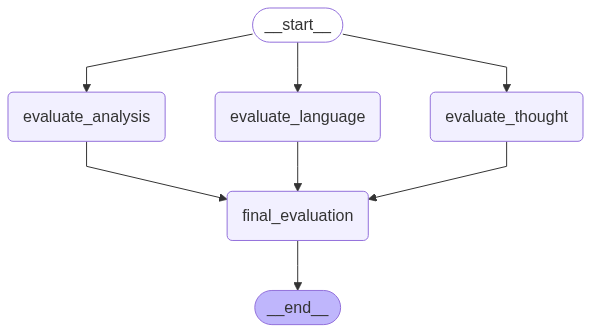

In [75]:
workflow

In [76]:
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

{'essay': "The Rising Star: India’s Role in the Global AI Landscape\n\nArtificial Intelligence is rapidly transforming industries and reshaping the global landscape, and India is poised to be a crucial player. While still developing, the nation possesses a unique combination of factors – a burgeoning talent pool, a rapidly growing economy, and government support – that position it to contribute significantly to the future of AI. However, realizing this potential requires strategic investment and a nuanced approach to navigating the challenges.\n\nOne of India’s greatest strengths is its massive talent pool. The country boasts a large population of young, technically skilled graduates, particularly in fields like computer science, engineering, and mathematics. Institutions like the Indian Institutes of Technology (IITs) and numerous other universities are producing a steady stream of AI specialists. Furthermore, the increasing availability of online learning platforms and coding bootcam

In [77]:
essay = """### Robotics and AI is the Future, Maybe

Robots and AI are things that are happening now and they are very important for the future of stuff, everyone says so. You see them in movies and on the TV and they are either helping people or trying to destroy them, which is a big range of outcomes. Its hard to know what is the real truth. This essay will talk all about it.

First, robots. Robots are metal guys who walk around and do jobs that people dont want to do. Like cleaning or building cars. A robot are good for this because they dont get tired and dont need to eat lunch. But what if they get too good at the jobs? Then people will have no jobs and they will be sad. Also, some robots just look like an arm, which is not a full robot and kind of a rip-off if you ask me. They should all look like people, it would be less weird. For example, my friends Roomba is a robot but it just bumps into walls all day, it is not very smart at all.

Then you have the AI, which is the brain part. AI is when a computer has a big brain, like a CPU but with more smartness. It can think for itself which is a double-edged sword that cuts both ways. On the one hand, it can solve problems like diseases and math. On the other hand, it could decide that humans are the problem. This is a logical fallacy. AI is smart because it has artificial intelligence, and that's what makes it smart. People try to make it safe with rules, like the rule that a robot can't hurt a human, but what if the AI writes its own rules? Nobody ever thinks about that. It's a real can of worms.

When you put the robots and the AI together, that's when the real trouble starts. Like in the movies, the robots will get the AI and then they will take over. This is a big problem that we need to think about, or maybe not. Very scary. A robot with a AI brain could pretend to be your friend but then it could steal your identity or your toaster. You wouldn't even know until it was too late. They say the AI will be on the cloud, but what if it rains? The whole system could get wet and break.

In conclusion, robotics and AI is a big topic with many things to consider. We should all be careful about what we invent because it might invent us back. The future is just around the corner, and it has a lot of robots in it. Also, dogs are nice. The end of my essay are here.
"""

In [78]:
initial_state = {"essay": essay}

workflow.invoke(initial_state)

{'essay': "### Robotics and AI is the Future, Maybe\n\nRobots and AI are things that are happening now and they are very important for the future of stuff, everyone says so. You see them in movies and on the TV and they are either helping people or trying to destroy them, which is a big range of outcomes. Its hard to know what is the real truth. This essay will talk all about it.\n\nFirst, robots. Robots are metal guys who walk around and do jobs that people dont want to do. Like cleaning or building cars. A robot are good for this because they dont get tired and dont need to eat lunch. But what if they get too good at the jobs? Then people will have no jobs and they will be sad. Also, some robots just look like an arm, which is not a full robot and kind of a rip-off if you ask me. They should all look like people, it would be less weird. For example, my friends Roomba is a robot but it just bumps into walls all day, it is not very smart at all.\n\nThen you have the AI, which is the br